# CNN using transfer learning in Keras

## Abstraction

What if we can detect cancer at early stage? In this competition, the challenge is to develop an model that can accurately identify metastatic cancer in small image patches extracted from larger digital pathology scans. The required task is to predict the probability, so it is not the classification but binary task.

This project goal is to develop a deep learning model using transfer learning to classify the image patches into positive or negative for metastatic cancer. We utilize the pretrained ResNet152 model as a feature extraction backbone and build a classifier on top of it, using some fully connected dense layers. The model is trained on a single GPU and evaluated using area under the ROC curve as the primary metric. We also monitor accuracy and validation loss during training to ensure optimal performance. We utilie hyper param tuning to get the appropriate learning rate for our model. After getting the final model, we make the submission file to get the final score of this kaggle's competition.

The link to the original competition is, https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview. You can get the same dataset as we used in this notebook.


**keywords**: binary classification, Keras, CNN, transfer learning, resnet152, image augumentation, hyper param tuning


### Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import models, layers, mixed_precision

train_dir = "/kaggle/input/histopathologic-cancer-detection/train"
test_dir = "/kaggle/input/histopathologic-cancer-detection/test"

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy) 
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

2.11.0
Compute dtype: float16
Variable dtype: float32


In [2]:
print("Traing Number: ", len(os.listdir(train_dir)))
print("Test Number: ", len(os.listdir(test_dir)))

Traing Number:  220025
Test Number:  57458


We get the training dataframe for later image loading. The trainingset has 2 classes, 0 for no cancer, 1 for at least 1 cancer. 40 % of training datasets are cancer images.

In [3]:
df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
print("Data's target distribution ((1) label num/ (1 + 0) label num): ", len(df[df.label == 1]) / len(df))
df.head()

Data's target distribution ((1) label num/ (1 + 0) label num):  0.40503124644926713


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
df.label = df.label.astype(str)
df.id = df.id + ".tif"
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


## EDA

The plot shows some training images. There are not obvious features that we find to classfiy which images indicate cancer or not. 

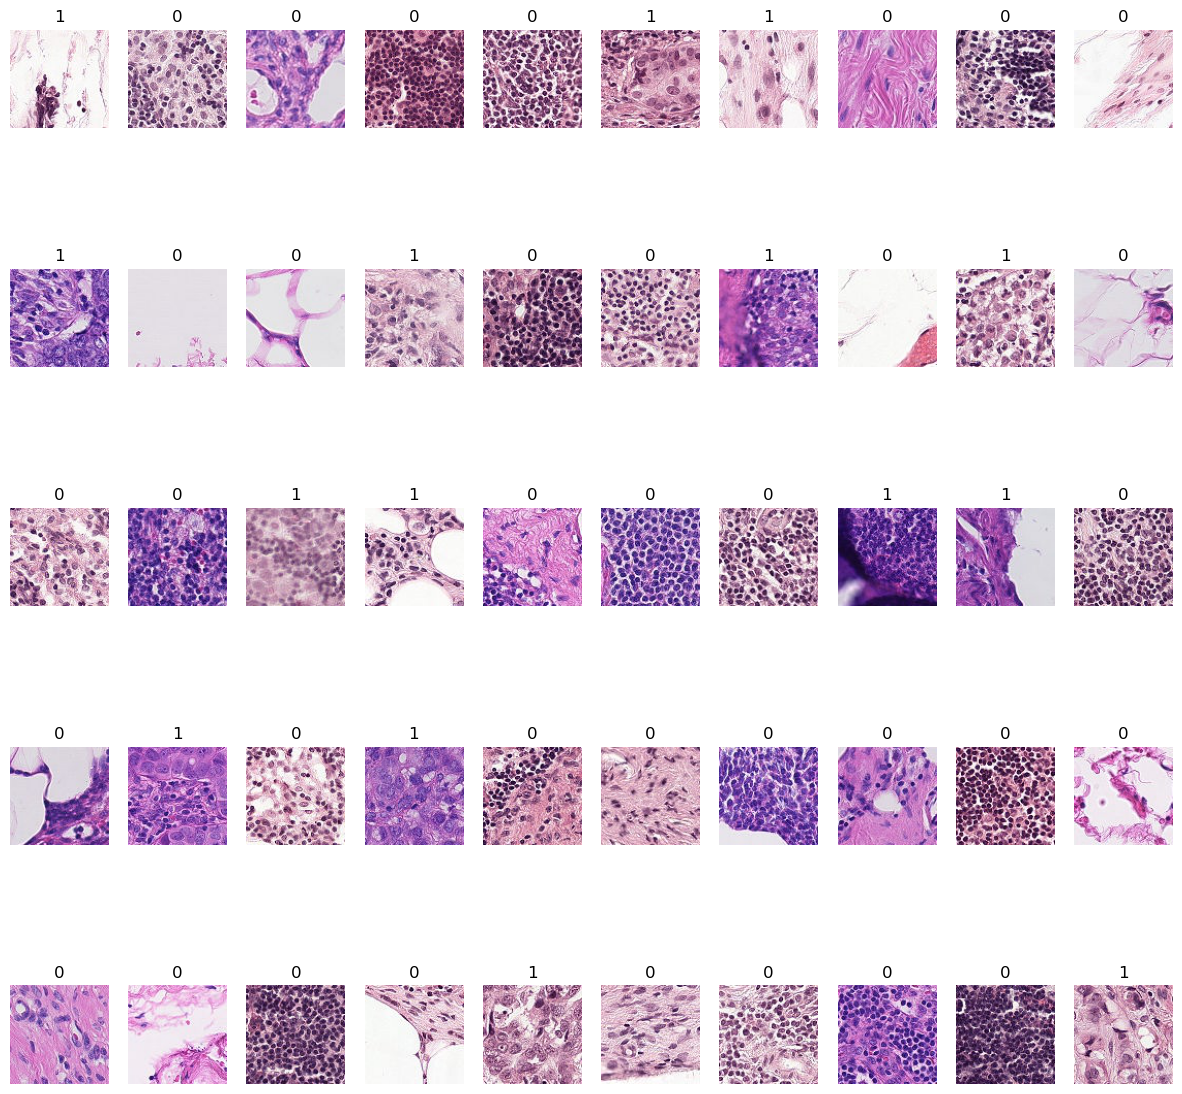

In [5]:
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
    img = plt.imread(train_dir + "/" + df.iloc[i]["id"])
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title(df.iloc[i]["label"])
    plt.imshow(img)
plt.show()

One image shape is `(width: 96, height: 96, color channel: 3)`.

Image shape:  (96, 96, 3)
Label:  0


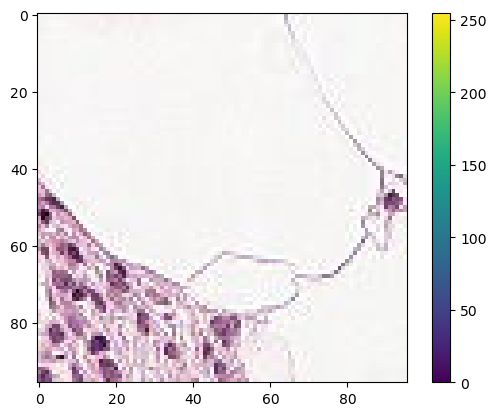

In [6]:
plt.figure()
img = plt.imread(train_dir + "/" + df.iloc[0]["id"])
print("Image shape: ", img.shape)
print("Label: ", df.iloc[0]["label"])
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

Belows codes are helper function we will use in model building and evaluating.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_train_val_generator(train_datagen, df, sample_frac=1.0, bs=64):
    df = df.sample(frac=sample_frac, random_state=42)
    
    train_generator = train_datagen.flow_from_dataframe(dataframe=df,
                                                       directory=train_dir,
                                                       x_col="id",
                                                       y_col="label",
                                                       subset="training",
                                                       target_size=(96, 96),
                                                       batch_size=bs,
                                                       class_mode="binary")
    valid_generator = train_datagen.flow_from_dataframe(dataframe=df,
                                                       directory=train_dir,
                                                       x_col="id",
                                                       y_col="label",
                                                       subset="validation",
                                                       target_size=(96, 96),
                                                       batch_size=bs,
                                                       shuffle=False,
                                                       class_mode="binary")
    return train_generator, valid_generator

def get_model(pretrained_model, preprocess_input):
    inputs = tf.keras.Input(shape=(96, 96, 3))
    # For feature extraction using transfer learning
    x = preprocess_input(inputs)
    x = pretrained_model(x) 
    # For classifier
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1)(x)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(x)
    
    return tf.keras.Model(inputs, outputs)

def fit_model(model, train_generator, valid_generator, epochs=5, callbacks=[]):
    return model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs=epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n//valid_generator.batch_size,
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=callbacks)

def plt_performance(train, valid, title):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(train, label='Training')
    plt.plot(valid, label='Validation')
    plt.legend(loc='upper left')
    plt.ylim([min(plt.ylim())-0.1,max(plt.ylim())+0.1])
    plt.title(title)

### Load sample training and validation set

We get 30% sample of all training data so that we can iterate our experiments more faster. Then dataset is split into 2 parts, training and validating. We treat validation set to see the model' performance while training. 

In [8]:
train_datagen = ImageDataGenerator(validation_split=0.2)
train_generator, valid_generator = get_train_val_generator(train_datagen, df, sample_frac=0.3)

Found 13201 validated image filenames belonging to 2 classes.


## Model Building and Evaluation

### Compare pretrained model

The pretrained models will be used as feature extraction layers. We compare each model's initial validaiton loss, and conclude to use `Resnet152` as our base model. The efficent net model would also seem good. However, after some training, resnet would have better performance among all.

In [9]:
preprocess_mobile = tf.keras.applications.mobilenet_v2.preprocess_input
mobilenet_v2 = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights="imagenet")

preprocess_res = tf.keras.applications.resnet_v2.preprocess_input
resnet_v2 = tf.keras.applications.ResNet152V2(input_shape=(96, 96, 3), include_top=False, weights="imagenet")

preprocess_incep = tf.keras.applications.inception_resnet_v2.preprocess_input
incep_v2 = tf.keras.applications.InceptionResNetV2(input_shape=(96, 96, 3), include_top=False, weights="imagenet")

preprocess_dense = tf.keras.applications.densenet.preprocess_input
dense = tf.keras.applications.DenseNet201(input_shape=(96, 96, 3), include_top=False, weights="imagenet")

preprocess_eff = tf.keras.applications.efficientnet.preprocess_input
effnet_b2 = tf.keras.applications.EfficientNetB2(input_shape=(96, 96, 3), include_top=False, weights="imagenet")

31790344/31790344 [==============================] - 0s 0us/step


In [10]:
models = [(mobilenet_v2, preprocess_mobile), (resnet_v2, preprocess_res), (incep_v2, preprocess_incep), (dense, preprocess_incep), (effnet_b2, preprocess_eff)]
for pretrained_model, preprocess in models:
    model = get_model(pretrained_model, preprocess)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"],)
    val_loss, val_acc = model.evaluate(valid_generator)
    print("\nPretrained Model: ", pretrained_model.name)
    print("Val Loss: ", val_loss)
    print("Val Acc: ", val_acc)

207/207 [==============================] - 116s 504ms/step - loss: 0.7215 - accuracy: 0.5254

Pretrained Model:  mobilenetv2_1.00_96
Val Loss:  0.7215186953544617
Val Acc:  0.525414764881134
207/207 [==============================] - 33s 138ms/step - loss: 0.6924 - accuracy: 0.5784

Pretrained Model:  resnet152v2
Val Loss:  0.692440390586853
Val Acc:  0.5783652663230896
207/207 [==============================] - 34s 138ms/step - loss: 0.8037 - accuracy: 0.4404

Pretrained Model:  inception_resnet_v2
Val Loss:  0.8036867380142212
Val Acc:  0.4404211938381195
207/207 [==============================] - 34s 137ms/step - loss: 0.7337 - accuracy: 0.4991

Pretrained Model:  densenet201
Val Loss:  0.733712911605835
Val Acc:  0.4991288483142853
207/207 [==============================] - 32s 130ms/step - loss: 0.6679 - accuracy: 0.5967

Pretrained Model:  efficientnetb2
Val Loss:  0.66792893409729
Val Acc:  0.596697211265564


## Model building and evaluation

On top of resnet model, we put 2 fully connected dense layers for classifier. The loss is `BinaryCrossEntropy` since this is binary task, and put label smooothing to `0.1`. This smoothing formula is, `y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing`. The optimizer is `Adam` with just quick learning rate. We tune this LR value at later part of this notebook. We chage the top 10 % resnet layer as trainable, holding other layers untrainable. It could increase the overfitting possibility, so we need to care for that. We see `Trainable params: 17,078,721` from model's summary, and we find this is good amount for this model and task. Thus, we keep it up and see the model's structure.

In [15]:
resnet_v2.trainable = True
print("Number of layers in the base net: ", len(resnet_v2.layers))

fine_tune_at = round(len(resnet_v2.layers) * 0.9)
print("Mobile model would be trainable from ", fine_tune_at)
for l in resnet_v2.layers[:fine_tune_at]:
    l.trainable = False
    
base_lr = 3e-3
model = get_model(resnet_v2, preprocess_res)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
             loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
             metrics=["accuracy"],)
print("Model trainable param number: ", len(model.trainable_variables))
model.summary()

Number of layers in the base net:  564
Mobile model would be trainable from  508
Model trainable param number:  61
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 96, 96, 3)        0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 3, 3, 2048)        58331648  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAv

One important layer when we use transfer learning is pretrained model's preprocess input layer. In our model's case, it is `tf.keras.applications.resnet_v2.preprocess_input`. The pretrained model is trained on this preprocessd data, so we need to convert our data as the same way before feeding it into the model. Therefore, we apply the same preprocessing function on our input data to ensure that it matches the input format of the pretrained ResNet152 model.

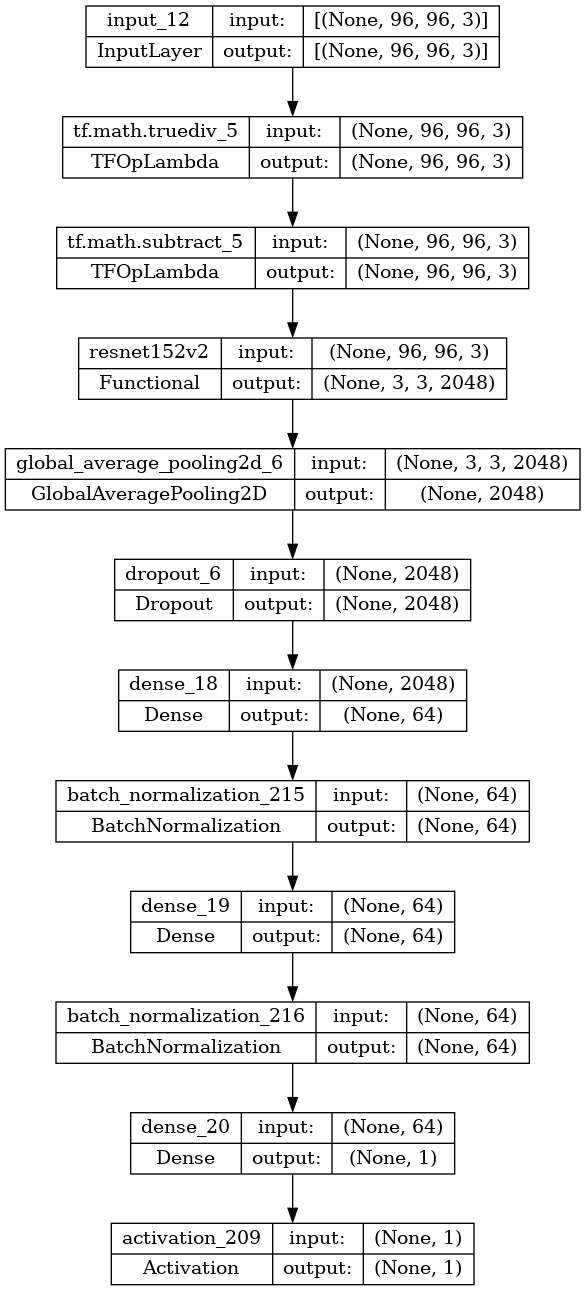

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Model training

We first iterate 3 epochs to see if the model can traing our dataset. It should the model have about `90` % accuracy on validation set in first 2 epoch. Hoever, at 3 poch, the model would somewhat overfit and less generalize with lower performance. It indicates that we need to deal with that overfitting. We add some treatment, like adding dropout and batchnomalization, but still overfittting exits. Therefre we decided to add more randomized image data, applying image augmentation for our models genelization.

Epoch 1/3
825/825 [==============================] - 136s 141ms/step - loss: 0.3583 - accuracy: 0.9047 - val_loss: 0.3485 - val_accuracy: 0.9088 - lr: 0.0030
Epoch 2/3
825/825 [==============================] - 105s 127ms/step - loss: 0.3297 - accuracy: 0.9221 - val_loss: 0.3550 - val_accuracy: 0.9053 - lr: 0.0030
Epoch 3/3
825/825 [==============================] - 113s 136ms/step - loss: 0.3045 - accuracy: 0.9386 - val_loss: 0.4825 - val_accuracy: 0.8404 - lr: 0.0029


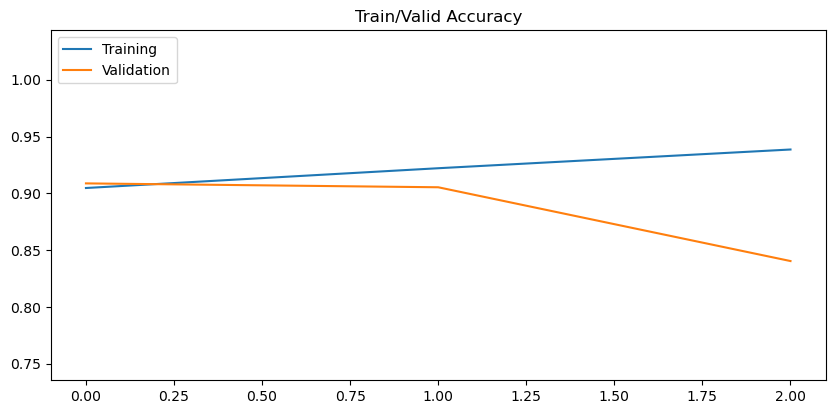

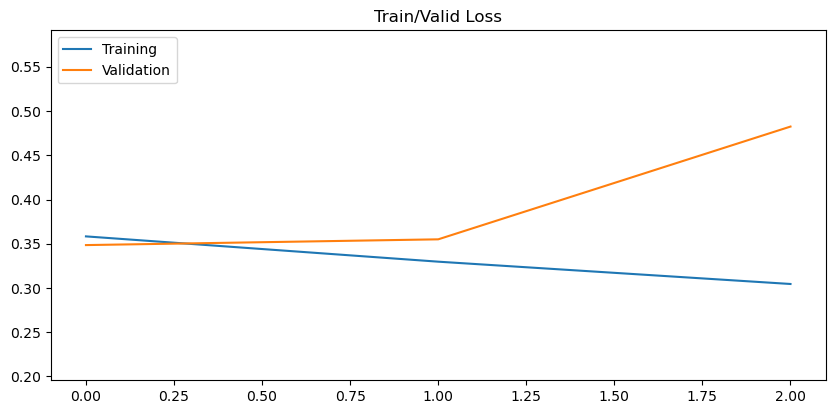

In [17]:
# Training
decay_steps = 20
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(base_lr, decay_steps)
callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)]
history = fit_model(model, train_generator, valid_generator, epochs=3, callbacks=callbacks)

# Evaluating
plt_performance(history.history["accuracy"], history.history["val_accuracy"], "Train/Valid Accuracy")
plt_performance(history.history["loss"], history.history["val_loss"], "Train/Valid Loss")

We apply some augmentation here at the stage of loading image datasets. Some random transformation would increase the training data and improve the model's validation performance. We didnot try test time augumentation(TTA), but it is also valid way to ease the overfitting.

In [18]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                      vertical_flip=True,
                                      horizontal_flip=True,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      zoom_range=0.2,
                                      )
train_aug_generator, valid_aug_generator = get_train_val_generator(train_datagen, df, sample_frac=0.3)

Found 52807 validated image filenames belonging to 2 classes.
Found 13201 validated image filenames belonging to 2 classes.


After loading augumented training dataset, we fit the model and see its performance. We can find the augumentation improve the model's validaiton accuracy with less overfitting.

Epoch 1/3
825/825 [==============================] - 321s 313ms/step - loss: 0.3979 - accuracy: 0.8750 - val_loss: 0.5211 - val_accuracy: 0.7994 - lr: 0.0030
Epoch 2/3
825/825 [==============================] - 247s 297ms/step - loss: 0.3499 - accuracy: 0.9079 - val_loss: 0.3362 - val_accuracy: 0.9120 - lr: 0.0030
Epoch 3/3
825/825 [==============================] - 258s 311ms/step - loss: 0.3390 - accuracy: 0.9154 - val_loss: 0.3647 - val_accuracy: 0.8984 - lr: 0.0029


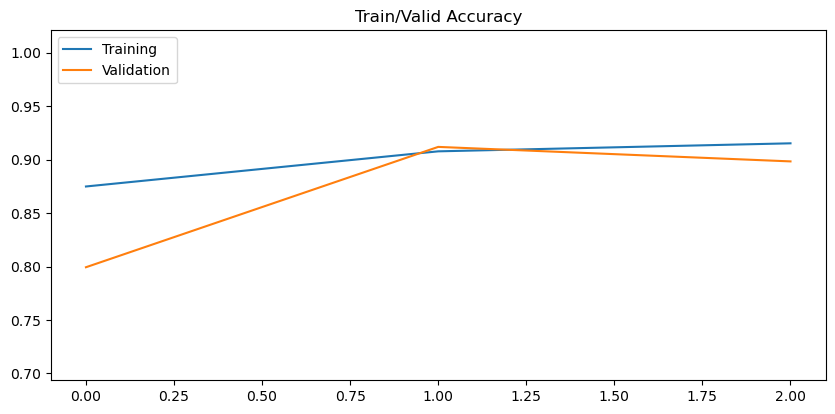

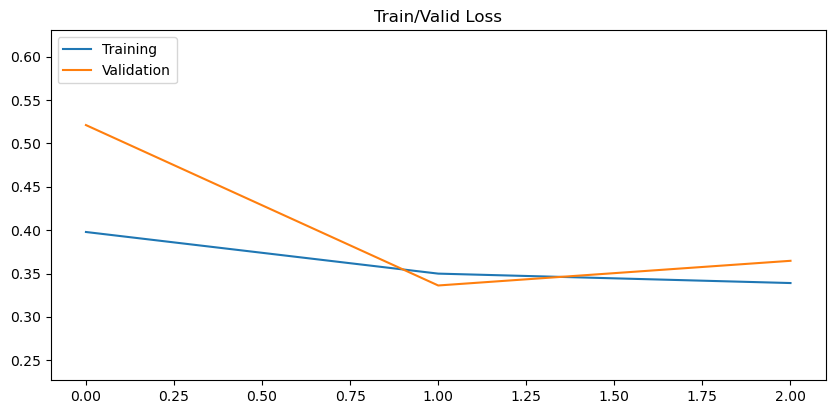

In [19]:
# Training
model = None
model = get_model(effnet_b2, preprocess_eff)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
             loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
             metrics=["accuracy"],)
history = fit_model(model, train_aug_generator, valid_aug_generator, epochs=3, callbacks=callbacks)

# Evaluating
plt_performance(history.history["accuracy"], history.history["val_accuracy"], "Train/Valid Accuracy")
plt_performance(history.history["loss"], history.history["val_loss"], "Train/Valid Loss")

### Hyper parameter tuning for better learning rate

So far we use some arbitray learning rate, but it could be better. We search more better LR using built in, `keras_tuner` and get the better one.

In [24]:
x_train, y_train = train_aug_generator.next()
x_val, y_val = valid_aug_generator.next()

In [27]:
import keras_tuner as kt

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = get_model(resnet_v2, preprocess_res)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value = 1e-4, max_value =1e-2, sampling='log')),
                     loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
                     metrics=["accuracy"],)

        return model

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=10
)

tuner.search(x_train, y_train,
             validation_data= (x_val,y_val), 
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Trial 5 Complete [00h 00m 36s]
val_loss: 0.5939831137657166

Best val_loss So Far: 0.47355833649635315
Total elapsed time: 00h 02m 56s


In [28]:
best_hps= tuner.get_best_hyperparameters(1)[0]
print("Best Learning Rate: ", best_hps.get('learning_rate'))

Best Learning Rate:  0.008838843007600081


### Model training with full training dataset

We test our final model on testset. We first load all training dataset and train our model with optimized hyper parameters. The fian model's accuracy are `0.95` on training set, and `0.93` on validation set.

In [31]:
train_full_generator, valid_full_generator = get_train_val_generator(train_datagen, df, sample_frac=1)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


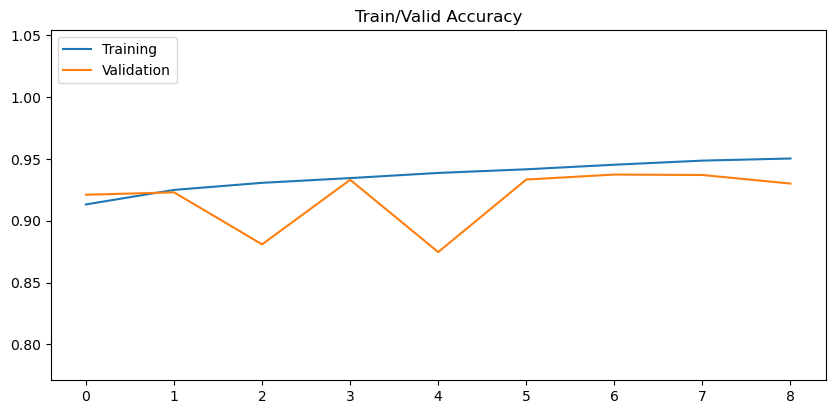

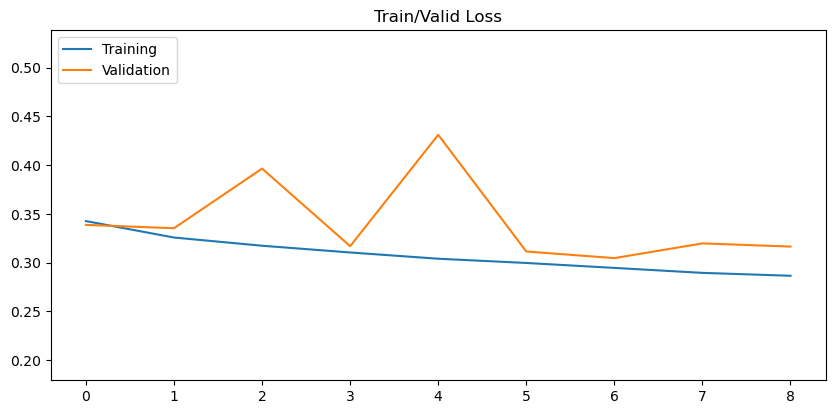

In [50]:
best_lr = 0.009
model = None
model = get_model(resnet_v2, preprocess_res)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
             loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
             metrics=["accuracy"],)

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(best_lr, 25)
callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn), tf.keras.callbacks.EarlyStopping(patience=2)]
history = fit_model(model, train_full_generator, valid_full_generator, epochs=12, callbacks=callbacks)

# Evaluating
plt_performance(history.history["accuracy"], history.history["val_accuracy"], "Train/Valid Accuracy")
plt_performance(history.history["loss"], history.history["val_loss"], "Train/Valid Loss")

### Model inference on testset

The code is for making submission file to get the final score on the original kaggle competition. 

In [47]:
df_test = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
df_test.id = df_test.id + ".tif"
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe=df_test,
                                                        directory=test_dir,
                                                        x_col="id",
                                                        y_col=None,
                                                        target_size=(96, 96),
                                                        batch_size=2,
                                                        shuffle=False,
                                                        class_mode=None)

test_generator.reset()
preds = model.predict(test_generator,verbose=1)

Found 57458 validated image filenames.
57458/57458 [==============================] - 2672s 46ms/step


In [49]:
submission = pd.DataFrame()
submission['id'] = df_test['id'].apply(lambda x: x.split('.')[0])
submission['label'] = preds[:, 0]
submission.to_csv('submission.csv', index=False)
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.048226
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.077239
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.051177
3,2c35657e312966e9294eac6841726ff3a748febf,0.060087
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.049222


## Discussion

### Result

We got `0.9272` on private score, while `0.9499` on public score from kaggle's submission.

### Ky findings

Here is what we learning in this project.

* Final layer's activation function needs to match the task specific one. This project is binary task, requiring us to predict the probability not the label, so sigmoid is appropriate choise. Some other notebooks use softmax but this might be wrong.
* Training takes a lot of time so we need to find a way to reduce it as much as possible. One way is subsampling the trainiing data while iterating and build the model. Another one is settin `use_multiprocessing=True, workers=4` on model.fit function to use multiple GPU.
* When we use pretrained model, we also need to use its own preproces input as well. In our case, we use `tf.keras.applications.resnet_v2.preprocess_input` before feeding our data to `tf.keras.applications.ResNet152V2`. That is must step to ensure better performance.
* Preventing overfit is necessary step, but we should take care of that only after that happend to us. At the first stege of model building, we should think about underfitting.
* Batchnormalization is strong way to prevent overfiting, but it worked well more with dropout layer in this problem.
* Image augumentation improve the overall accuracy with less overfitting, while taking more time to train the model.
* Overall more layers and more data improve the model's accuracy. 

## Conclusion

The final model achieved a private score of 0.9272 and a public score of 0.9499 on Kaggle's competition. This project aimed to develop a deep learning model using transfer learning to detect metastatic cancer in small image patches extracted from larger digital pathology scans. The model utilized the ResNet152 model as a feature extraction backbone and fully connected dense layers as the classifier. The model was trained using area under the ROC curve as the primary metric, and accuracy and validation loss were monitored during training. Key findings from the project included the importance of matching the final layer's activation function to the task, using the pretrained model's preprocess input, preventing underfitting, utilizing batch normalization and dropout layers to prevent overfitting, and the effectiveness of image augmentation in improving accuracy while preventing overfitting. Overall, increasing the number of layers and data improved the model's accuracy.

## Referrences

* tensorflow and keras tutorial: https://www.tensorflow.org/tutorials
* pretrained keras model: https://keras.io/api/applications/
* tip for speed training time up: https://analyticsindiamag.com/7-tricks-to-speed-up-the-training-of-a-neural-network/
* keras hyper param tuning for LR: https://blog.paperspace.com/hyperparameter-optimization-with-keras-tuner/
* multipe image plots: https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
* kaggle notebook about building CNN from scrach: https://www.kaggle.com/code/hrmello/base-cnn-classification-from-scratch?scriptVersionId=7628679
* tutorial for keras flow_from_dataframe: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c